In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import Lmer
from scipy.stats import pearsonr
from prp_visu import *
DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
labels = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
labels_cmb = labels_t1 + labels_t2[1:]
legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
# legible_labels = ["T1 Encoding", "T1 Central", "T1 Response", "T2 Encoding", "T2 Central", "T2 Response"]
# orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5), (0, 3, 4, 1, 2, 5)]
orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5)]
set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)

### Combined tasks

In [24]:
def determine_order(paths: list[Path], labels: list[list[str]]):
    df_t1 = pd.read_csv(paths[0])
    df_t2 = pd.read_csv(paths[1])
    # Combine dataframes on 'epoch' and 'participant'
    df = df_t1.merge(
        df_t2, on=["condition", "epoch", "participant"], suffixes=("_t1", "_t2")
    )
    labels_t1 = labels[0]
    labels_t2 = labels[1]
    pred_cols_t1 = [labels_t1[i] + "_pred" for i in range(1, len(labels_t1))]
    pred_cols_t2 = [labels_t2[i] + "_pred" for i in range(1, len(labels_t2))]

    # Add ISI to task 2 predictions to get absolute time
    df[pred_cols_t2] = df[pred_cols_t2].add(df["interval_t1"] * 250, axis=0)

    peak_order = df[pred_cols_t1 + pred_cols_t2].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols_t1 + pred_cols_t2):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df

def determine_order_cmb(path):
    df = pd.read_csv(path)
    df_t1 = df[df["task"] == "prp1/t1"].copy()
    df_t2 = df[df["task"] == "prp1/t2"].copy()
    
    df_t1["correct_t1"] = df_t1["correct"]
    df_t2["correct_t2"] = df_t2["correct"]
    df_t1["rt_t1"] = df_t1["rt_samples"]
    df_t2["rt_t2"] = df_t2["rt_samples"]

    id_cols = ["participant", "epoch"]
    meta_cols = ["condition", "interval", "rt_t1", "rt_samples"]
    t1_cols = [col for col in df.columns if col.startswith("t1_")]
    t2_cols = [col for col in df.columns if col.startswith("t2_")]


    df_t1_reduced = df_t1[id_cols + meta_cols + ["correct_t1"] + t1_cols]
    df_t2_reduced = df_t2[id_cols + ["correct_t2", "rt_t2"] + t2_cols]

    df_merged_fixed = pd.merge(df_t1_reduced, df_t2_reduced, on=id_cols, how="inner")

    t1_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t1_") and col.endswith("_pred")]
    t2_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t2_") and col.endswith("_pred")]
    df_merged_fixed[t2_pred_cols] = df_merged_fixed[t2_pred_cols].add(df_merged_fixed["interval"] * 250, axis=0)

    peak_order = df_merged_fixed[t1_pred_cols + t2_pred_cols].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(t1_pred_cols + t2_pred_cols):
        df_merged_fixed[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df_merged_fixed

def remove_rare_orders(df: pd.DataFrame, labels: list[list[str]]):
    # Create a column with order tuples
    order_columns = [
        f"event_{i}_idx" for i in range(len(labels[0]) + len(labels[1]) - 2)
    ]
    df["order"] = df[order_columns].apply(tuple, axis=1)

    # Count number of (order, condition) pairs
    order_condition_counts = df.groupby(["order", "condition"]).size()
    print(order_condition_counts)
    # Calculate 1.5% threshold per condition
    condition_counts = df["condition"].value_counts()
    thresholds = condition_counts * 0.015

    # Keep only (order, condition) pairs above threshold
    valid_combinations = [
        (order, condition)
        for (order, condition), count in order_condition_counts.items()
        if count >= thresholds[condition]
    ]

    # Filter the DataFrame
    df = df[df.set_index(["order", "condition"]).index.isin(valid_combinations)]

    # Re-index orders
    unique_orders = df["order"].unique()
    order_mapping = {order: idx for idx, order in enumerate(unique_orders)}
    df["order_idx"] = df["order"].map(order_mapping)

    return df

In [3]:
paths = [Path("files/t1_peaks.csv"), Path("files/t2_peaks.csv")]
df = determine_order(paths, [labels_t1, labels_t2])
df = remove_rare_orders(df, [labels_t1, labels_t2])
# Filter out rows where condition == long and participant is in splits[0]
df_no_val = df.copy()[~((df["condition"] == "long") & (df["participant"].isin(splits[0])))]

/tmp/ipykernel_2602216/3367412807.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


In [25]:
df = determine_order_cmb(Path("files/cmb_peaks.csv"))
df = remove_rare_orders(df, [labels_t1, labels_t2])
df_no_val = df.copy()[~((df["condition"] == "long") & (df["participant"].isin(splits[0])))]

order               condition
(0, 1, 2, 3, 4, 5)  long         10925
                    short          774
(0, 1, 3, 2, 4, 5)  long            75
                    short         5422
(0, 1, 3, 4, 2, 5)  long             7
                    short          634
(0, 1, 4, 3, 2, 5)  short            1
(0, 3, 1, 2, 4, 5)  long             4
                    short         3059
(0, 3, 1, 4, 2, 5)  long             4
                    short         1708
(0, 3, 1, 4, 5, 2)  short            3
(0, 3, 4, 1, 2, 5)  short          181
(0, 3, 4, 1, 5, 2)  short            2
(0, 3, 4, 5, 1, 2)  short            4
(1, 0, 2, 3, 4, 5)  long             2
dtype: int64


/tmp/ipykernel_3466532/4247609149.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


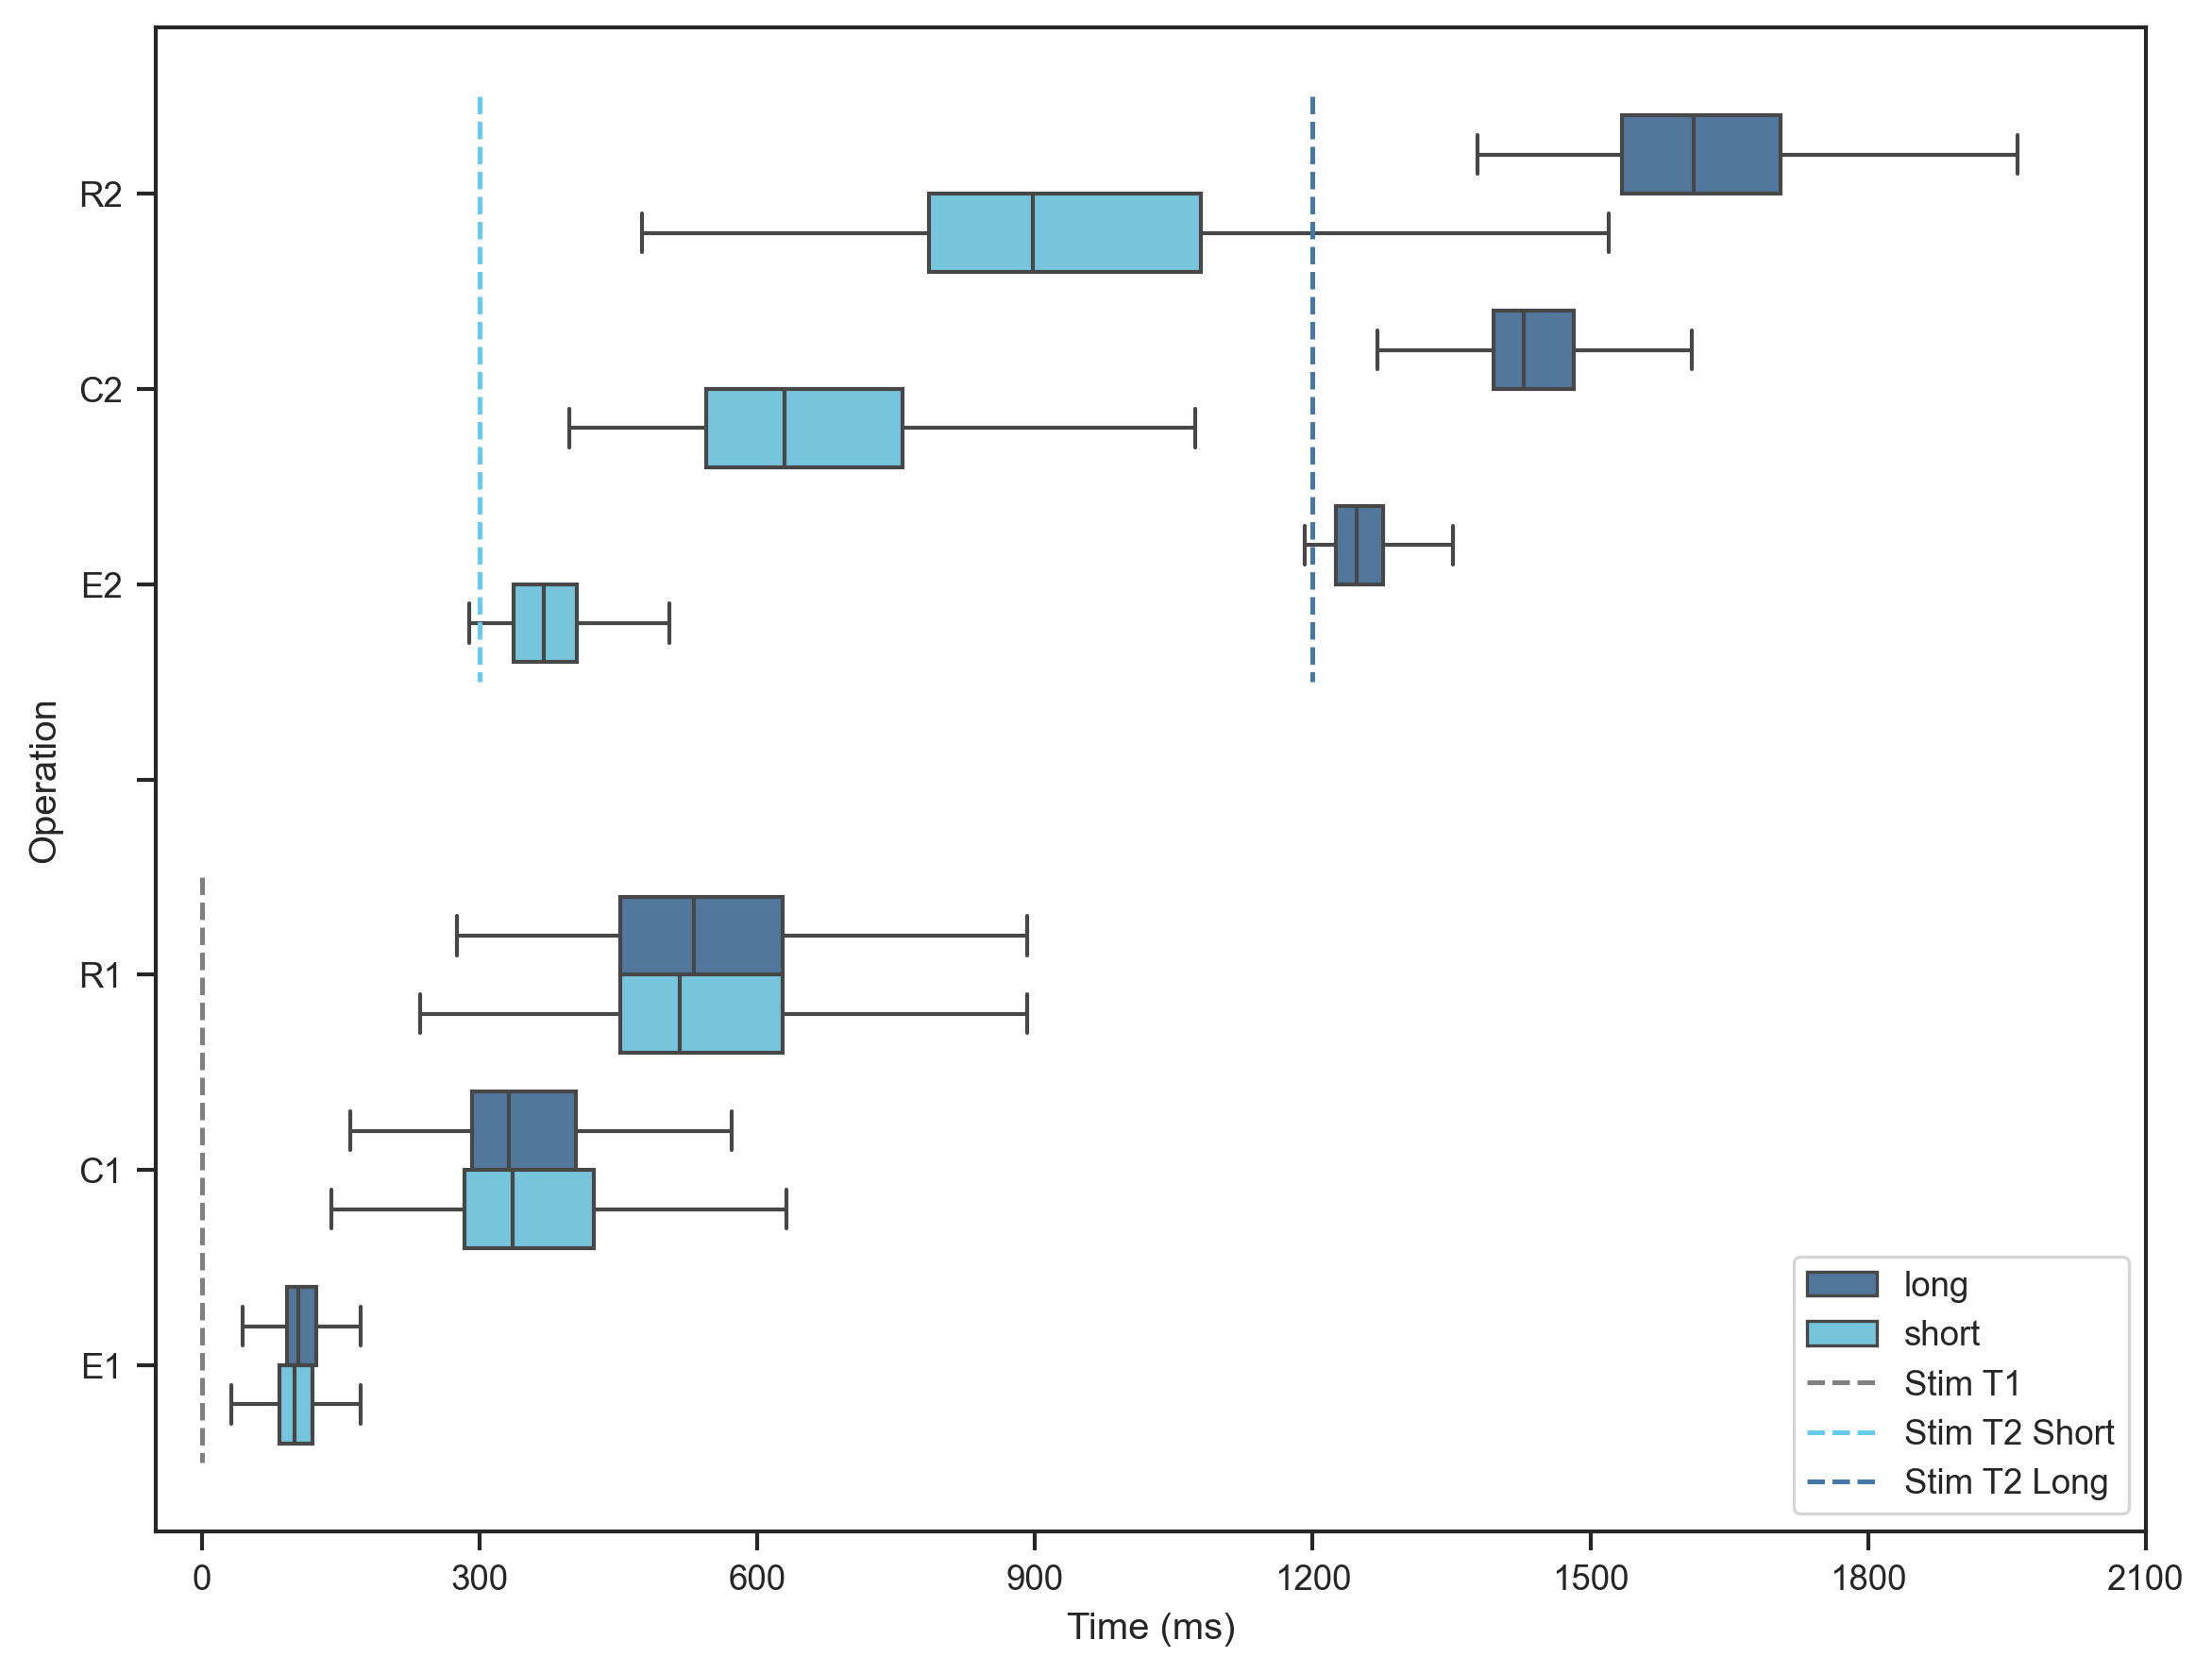

In [15]:
fig = plot_timing_in_trial(df_no_val, legible_labels)
fig.show()

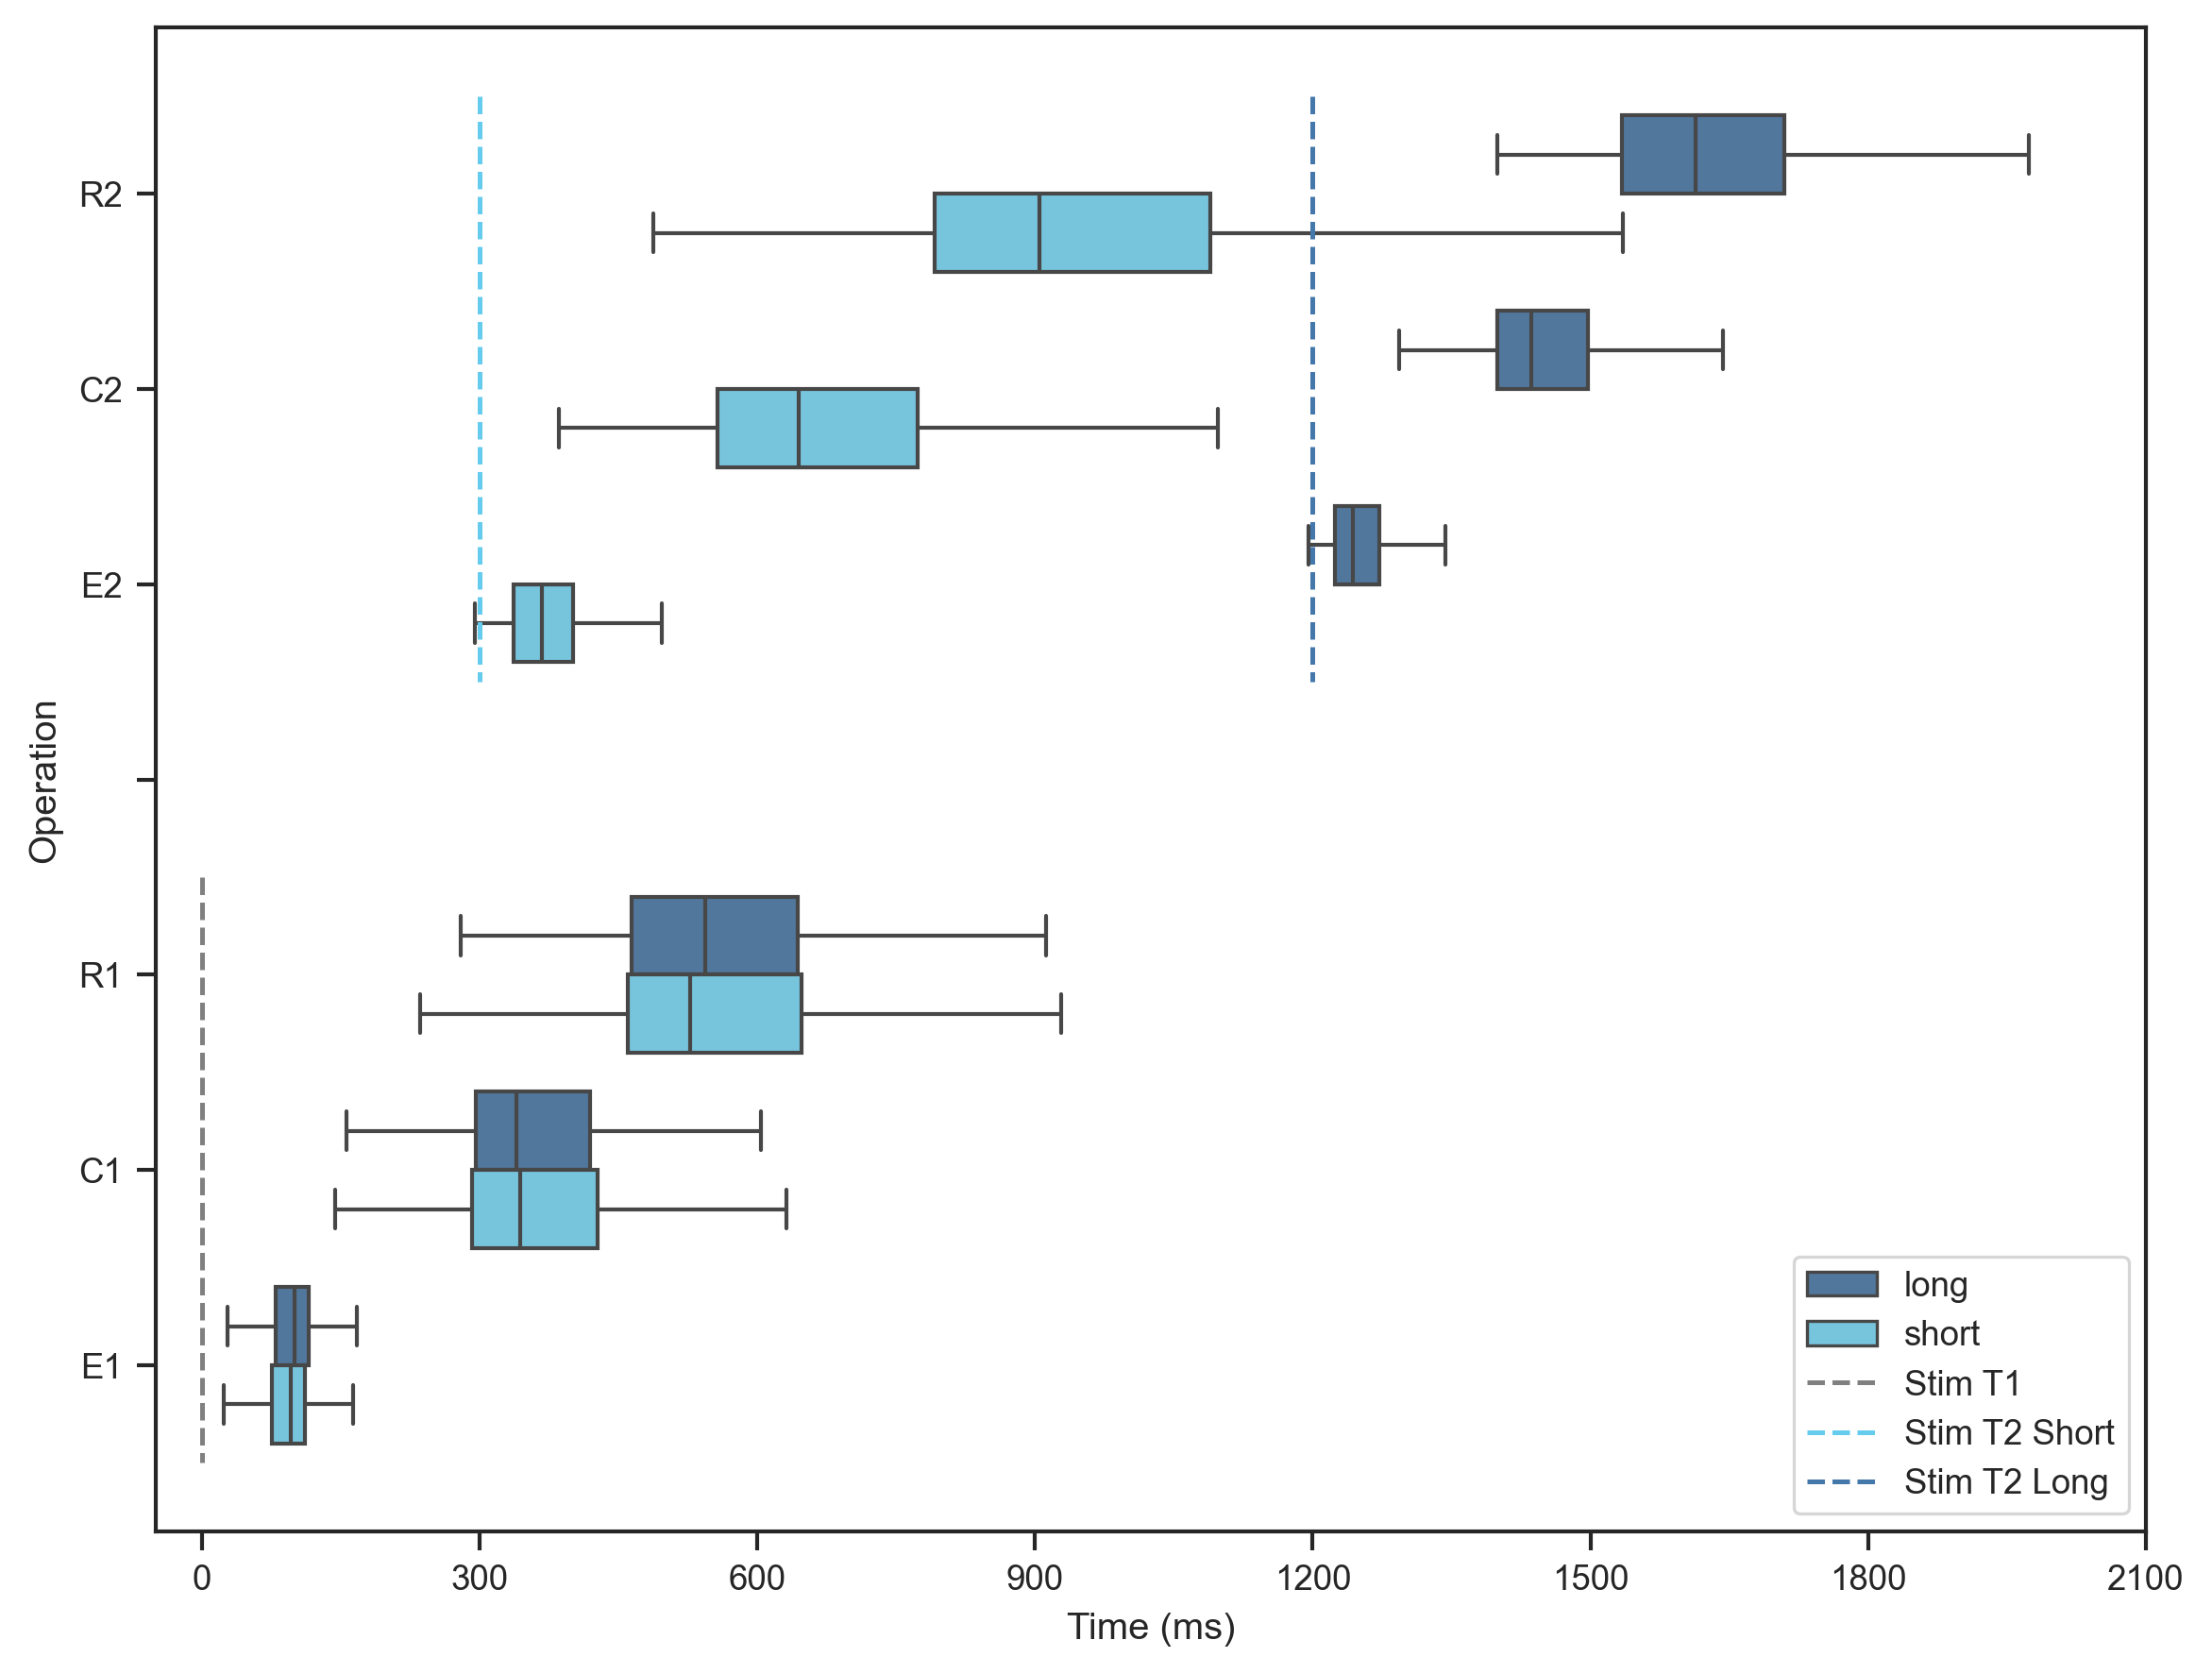

In [26]:
fig = plot_timing_in_trial(df_no_val, legible_labels)
fig.show()

### Check whether short E2 is later than long E2 (stimulus-provoked should be at the same time?)

In [6]:
df_no_val

,condition,epoch,participant,interval_t1,correct_t1,correct_t1_t1,correct_t2_t1,rt_t1_t1,rt_samples_t1,t1_1_pred,...,t2_3_true,t2_3_peak_values,event_0_idx,event_1_idx,event_2_idx,event_3_idx,event_4_idx,event_5_idx,order,order_idx
1,short,502.0,VP3,0.277344,1.0,NaN,NaN,NaN,127,22.0,...,129.0,"[-1.8115649223327637, -1.5504462718963623, -2....",0,1,3,2,4,5,"(0, 1, 3, 2, 4, 5)",1
3,short,293.0,VP3,0.275391,1.0,NaN,NaN,NaN,161,23.0,...,190.0,"[-7.589505672454834, -5.9596123695373535, -0.1...",0,1,3,2,4,5,"(0, 1, 3, 2, 4, 5)",1
4,short,722.0,VP21,0.277344,1.0,NaN,NaN,NaN,103,24.0,...,76.0,"[-0.0088952062651515, 1.3353687524795532, -0.6...",0,1,3,2,4,5,"(0, 1, 3, 2, 4, 5)",1
5,short,25.0,VP16,0.277344,1.0,NaN,NaN,NaN,124,31.0,...,117.0,"[0.6594937443733215, -1.9407429695129395, -0.9...",0,3,1,2,4,5,"(0, 3, 1, 2, 4, 5)",2
6,short,1032.0,VP21,0.277344,1.0,NaN,NaN,NaN,167,33.0,...,107.0,"[-0.7461596727371216, 0.5632293224334717, -0.6...",0,3,1,4,2,5,"(0, 3, 1, 4, 2, 5)",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22806,short,579.0,VP16,0.277344,1.0,NaN,NaN,NaN,134,18.0,...,113.0,"[0.17159049212932587, 2.0046474933624268, -0.4...",0,1,3,4,2,5,"(0, 1, 3, 4, 2, 5)",4
22812,short,522.0,VP23,0.277344,1.0,NaN,NaN,NaN,162,25.0,...,180.0,"[0.6825559735298157, 1.072721004486084, 1.8824...",0,3,1,2,4,5,"(0, 3, 1, 2, 4, 5)",2
22815,short,156.0,VP1,0.277344,1.0,NaN,NaN,NaN,180,22.0,...,173.0,"[-2.211791753768921, -2.0785467624664307, -1.5...",0,3,1,2,4,5,"(0, 3, 1, 2, 4, 5)",2
22816,short,309.0,VP23,0.277344,0.0,NaN,NaN,NaN,134,29.0,...,232.0,"[0.25239303708076477, -0.7717839479446411, -0....",0,1,3,2,4,5,"(0, 1, 3, 2, 4, 5)",1


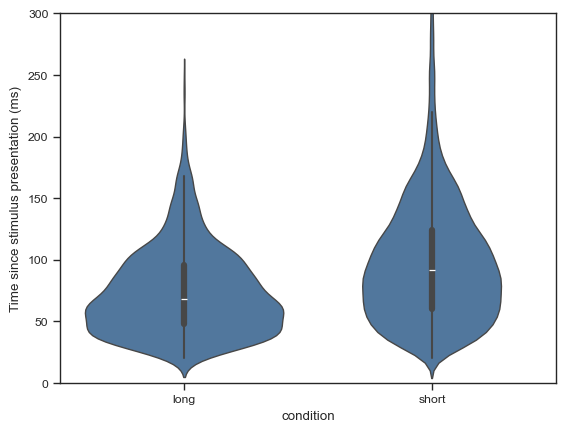

T-statistic: -20.72493343733575, P-value: 5.460000482335498e-94


In [28]:
df_no_val_e2 = df_no_val.copy()
set_seaborn_style()
# Subtract interval to get time since stimulus presentation
df_no_val_e2['t2_1_pred'] = df_no_val_e2['t2_1_pred'].subtract(df_no_val_e2['interval'] * 250, axis=0)
df_no_val_e2['t2_1_pred'] = df_no_val_e2['t2_1_pred'] * 1000 / 250

sns.violinplot(df_no_val_e2, x="condition", y="t2_1_pred", order=["long", "short"])
plt.ylim(0, 300)
plt.ylabel("Time since stimulus presentation (ms)")

plt.show()
# Do t-test between e2_long and e2_short
from scipy.stats import ttest_ind
e2_long = df_no_val_e2[df_no_val_e2["condition"] == "long"]['t2_1_pred']
e2_short = df_no_val_e2[df_no_val_e2["condition"] == "short"]['t2_1_pred']
t_stat, p_value = ttest_ind(e2_long, e2_short)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

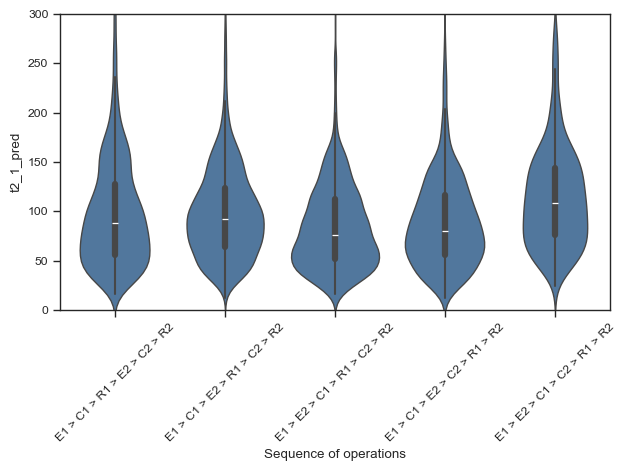

In [30]:
# Correct
set_seaborn_style()
sns.violinplot(df_no_val_e2, x="order_idx", y="t2_1_pred")
xticks = [' > '.join([legible_labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=45)
plt.ylim(0, 300)
plt.xlabel("Sequence of operations")
# plt.ylabel("Task 2 accuracy")
plt.tight_layout()
plt.show()

### Replacement of RT graph

In [17]:
def rt_order_regression(df, task: str = "t1"):
    df = df.copy()
    df = df[["participant", "condition", f"rt_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = f"rt_{task} ~ condition + (1|participant)"
    model = Lmer(formula, data=df)

    model.fit(verbose=False)

    print(model.summary())
    return model

df_no_val["rt_t1"] = df_no_val["rt_samples_t1"] / 250 * 1000
df_no_val["rt_t2"] = df_no_val["rt_samples_t2"] / 250 * 1000

model_rt_order_t1 = rt_order_regression(df_no_val, task="t1")
model_rt_order_t2 = rt_order_regression(df_no_val, task="t2")

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13760	 Groups: {'participant': 21.0}

Log-likelihood: -89501.870 	 AIC: 179011.739

Random effects:

                    Name        Var      Std
participant  (Intercept)  10228.274  101.135
Residual                  25946.796  161.080

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13760	 Groups: {'participant': 21.0}

Log-likelihood: -89501.870 	 AIC: 179011.739

Random effects:

                    Name        Var      Std
participant  (Intercept)  10228.274  101.135
Residual                  25946.796  161.080

No random effect correlations specified

Fixed effects:

                Estimate   2.5_ci  97.5_ci      SE         DF  T-stat  P-val  \
(Intercept)      624.231  580.01

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [18]:
def get_means_and_errors(model):
    coefs = model.coefs
    intercept = coefs["Estimate"].iloc[0]
    intercept_SE = coefs["SE"].iloc[0]
    means = [intercept]
    errors = [1.96 * intercept_SE]
    for row in coefs.index[1:]:
        row_intercept = intercept + coefs["Estimate"].loc[row]
        means.append(row_intercept)
        row_SE = coefs["SE"].loc[row]
        row_SE = np.sqrt(intercept_SE**2 + row_SE**2)
        row_error = 1.96 * row_SE
        errors.append(row_error)
    df = pd.DataFrame({
        "condition": coefs.index,
        "mean": means,
        "error": errors
    })
    return df


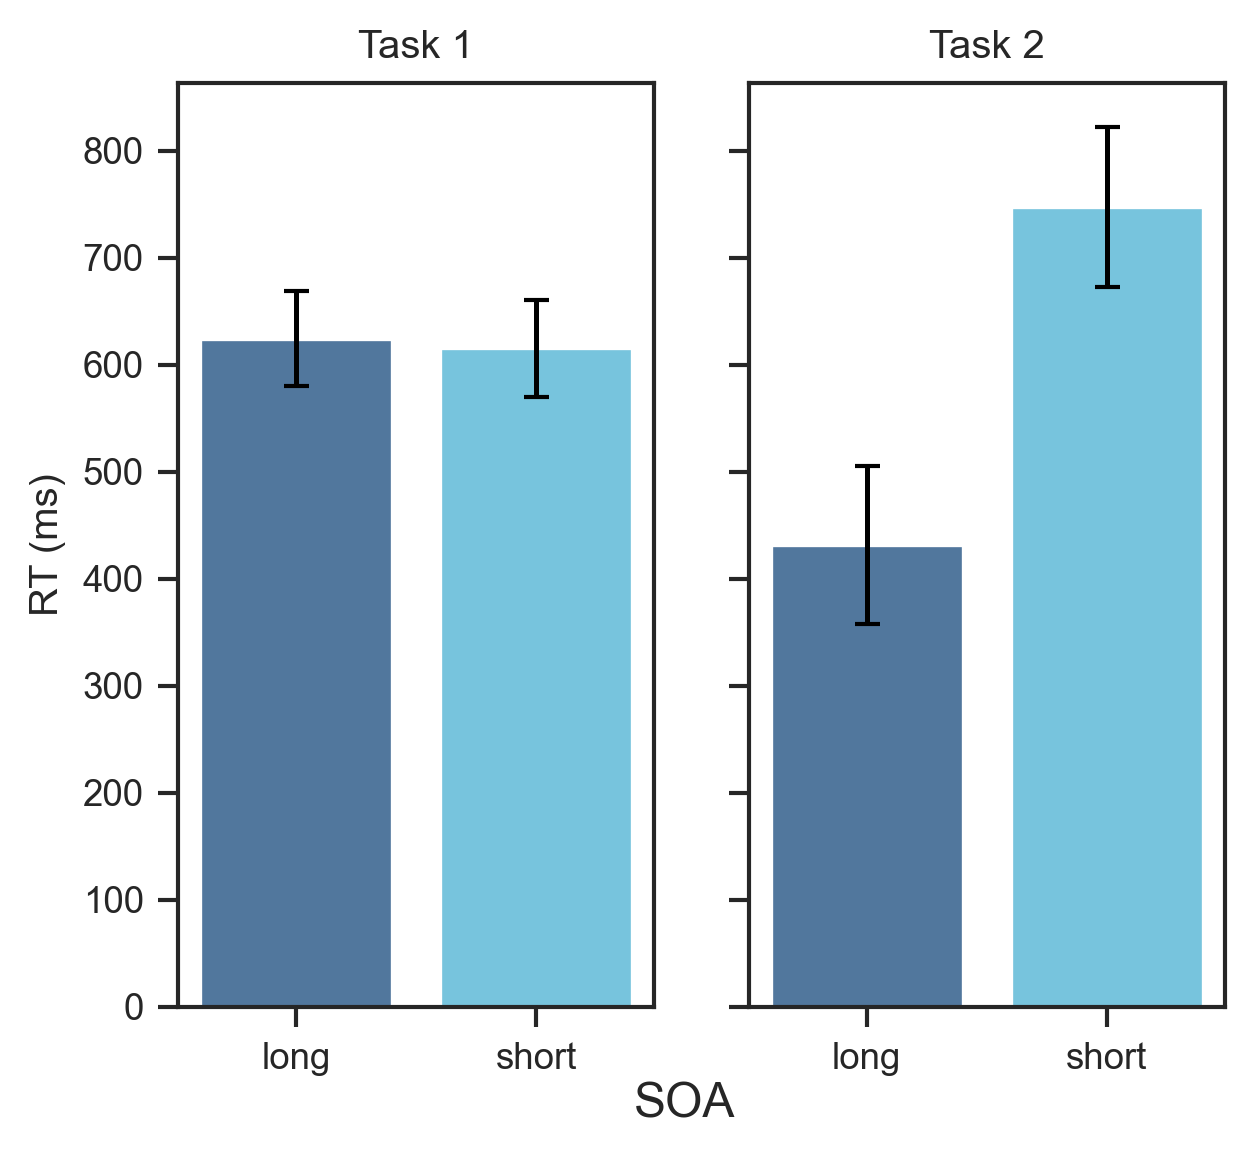

In [19]:
set_seaborn_style()
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=300, figsize=(4.5, 4))
t1_me = get_means_and_errors(model_rt_order_t1)
sns.barplot(t1_me, x="condition", y="mean", ax=axes[0], hue='condition')
for i, row in t1_me.iterrows():
    axes[0].errorbar(i, row["mean"], yerr=row["error"], fmt='none', capsize=3, color='black')
axes[0].set_xticks([0, 1], ["long", "short"])
axes[0].set_xlabel("")
axes[0].set_title("Task 1")

t2_me = get_means_and_errors(model_rt_order_t2)
sns.barplot(t2_me, x="condition", y="mean", ax=axes[1], hue='condition')
for i, row in t2_me.iterrows():
    axes[1].errorbar(i, row["mean"], yerr=row["error"], fmt='none', capsize=3, color='black')
axes[1].set_xticks([0, 1], ["long", "short"])
axes[1].set_xlabel("")
axes[1].set_title("Task 2")
fig.supxlabel("SOA")
axes[0].set_ylabel("RT (ms)")
plt.show()

### Behavior (Correct/RT) / Order

In [29]:
def performance_order_regression(df, task: str = "t1"):
    correct_col = f"correct_{task}"
    df = df.copy()
    df = df[["participant", "order_idx", correct_col, "condition"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = f"{correct_col} ~ order_idx + condition + (1|participant)"
    model = Lmer(formula, data=df, family="binomial")

    model.fit(verbose=False)

    print(model.summary())
    return model
model_perf = performance_order_regression(df_no_val, task="t2")

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct_t2~order_idx+condition+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 13763	 Groups: {'participant': 21.0}

Log-likelihood: -4523.209 	 AIC: 9062.417

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.421  0.649

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct_t2~order_idx+condition+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 13763	 Groups: {'participant': 21.0}

Log-likelihood: -4523.209 	 AIC: 9062.417

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.421  0.649

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)        2.205   1.869    2.542  0.171  9.074      6.484   
order_idx1         0.207  -0.021

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [30]:
from scipy.special import expit

coefs = model_perf.coefs

# Base intercept (reference condition)
intercept = coefs.loc["(Intercept)", "Estimate"]
intercept_low = coefs.loc["(Intercept)", "2.5_ci"]
intercept_high = coefs.loc["(Intercept)", "97.5_ci"]
intercept_short = intercept + coefs.loc["conditionshort", "Estimate"]
intercept_short_low = intercept_low + coefs.loc["conditionshort", "2.5_ci"]
intercept_short_high = intercept_high + coefs.loc["conditionshort", "97.5_ci"]

probs = []

probs.append({"condition": "long", "order_idx": 0, "proba": expit(intercept), "err": (expit(intercept_high) - expit(intercept_low)) / 2})
probs.append({"condition": "short", "order_idx": 0, "proba": expit(intercept_short), "err": (expit(intercept_short_high) - expit(intercept_short_low)) / 2})

for _, row in coefs.iterrows():
    if row.name.startswith("order_idx"):
        order_idx = int(row.name.split("x")[-1])
        proba = expit(intercept_short + row["Estimate"])
        err = (expit(intercept_short_high + row["97.5_ci"]) - expit(intercept_short_low + row["2.5_ci"])) / 2
        probs.append({"condition": "short", "order_idx": order_idx, "proba": proba, "err": err})
probs = pd.DataFrame(probs)

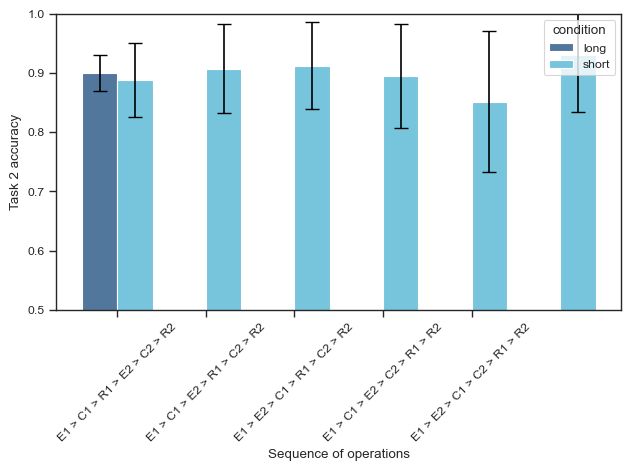

In [31]:
# Correct
set_seaborn_style()
ax = sns.barplot(data=probs, x="order_idx", y="proba", hue="condition", errorbar=None)
for i, row in probs.iterrows():
    ax.errorbar(row["order_idx"] + 0.2 if row["condition"] == "short" else row["order_idx"] - 0.2, 
                row["proba"], yerr=row["err"], fmt='none', capsize=5, color='black')
xticks = [' > '.join([legible_labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=45)
plt.ylim(0.5, 1)
plt.xlabel("Sequence of operations")
plt.ylabel("Task 2 accuracy")
plt.tight_layout()
plt.show()

In [ ]:
# Post-hoc multiple comparisons, compare all order_idxs with each other
contrasts = model_perf.post_hoc("order_idx", p_adjust="holm")
print(contrasts)

In [12]:
df["rt_t1"] = df["rt_samples_t1"] / 250 * 1000

In [32]:
def rt_order_regression(df):
    df = df.copy()
    # df = df[df["condition"] == "short"]
    df = df[["participant", "rt_t1", "order_idx", "condition"]]
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = "rt_t1 ~ order_idx + condition + (1|participant)"
    model = Lmer(formula, data=df)

    model.fit(verbose=False)

    print(model.summary())
    return model
model_rt = rt_order_regression(df_no_val)

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~order_idx+condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13864	 Groups: {'participant': 21.0}

Log-likelihood: -68578.058 	 AIC: 137174.116

Random effects:

                    Name       Var     Std
participant  (Intercept)   358.218  18.927
Residual                  1151.610  33.935

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~order_idx+condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13864	 Groups: {'participant': 21.0}

Log-likelihood: -68578.058 	 AIC: 137174.116

Random effects:

                    Name       Var     Std
participant  (Intercept)   358.218  18.927
Residual                  1151.610  33.935

No random effect correlations specified

Fixed effects:

                Estimate   2.5_ci  97.5_ci     SE         DF  T-stat  P-val  \
(Intercept)      151.897 

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [33]:
def get_means_and_errors_condition(model):
    coefs = model.coefs
    intercept = coefs["Estimate"].iloc[0]
    intercept_SE = coefs["SE"].iloc[0]
    intercept_short = intercept + coefs["Estimate"].iloc[-1]
    intercept_short_SE = intercept_SE**2 + coefs["SE"].iloc[-1]**2
    means = [intercept, intercept_short]
    errors = [1.96 * intercept_SE, 1.96 * np.sqrt(intercept_short_SE)]
    conditions = ["long", "short"]
    order_idxes = [0, 0]

    for row in coefs.index[1:-1]:
        row_intercept = intercept + coefs["Estimate"].loc[row]
        means.append(row_intercept)
        row_SE = coefs["SE"].loc[row]
        row_SE = np.sqrt(row_SE**2 + intercept_short_SE)
        row_error = 1.96 * row_SE
        errors.append(row_error)
        conditions.append("short")
        order_idxes.append(int(row[-1]))

    df = pd.DataFrame({
        "condition": conditions,
        "order_idx": order_idxes,
        "mean": means,
        "error": errors
    })
    return df


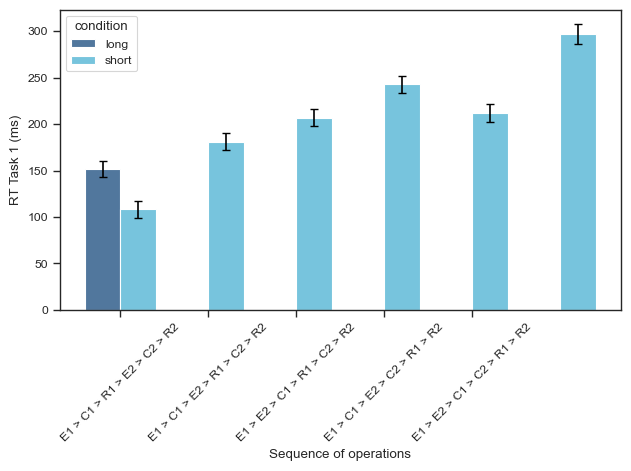

In [34]:
rt_me = get_means_and_errors_condition(model_rt)
set_seaborn_style()
ax = sns.barplot(data=rt_me, x="order_idx", y="mean", hue="condition", errorbar=None)
xticks = [' > '.join([legible_labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=45)
plt.xlabel("Sequence of operations")
for i, row in rt_me.iterrows():
    if i == 0:
        i_pos = -0.2
    else:
        i_pos = (i - 1) + 0.2
    ax.errorbar(i_pos, row["mean"], yerr=row["error"], fmt='none', capsize=3, color='black')
plt.ylabel("RT Task 1 (ms)")
plt.tight_layout()
plt.show()

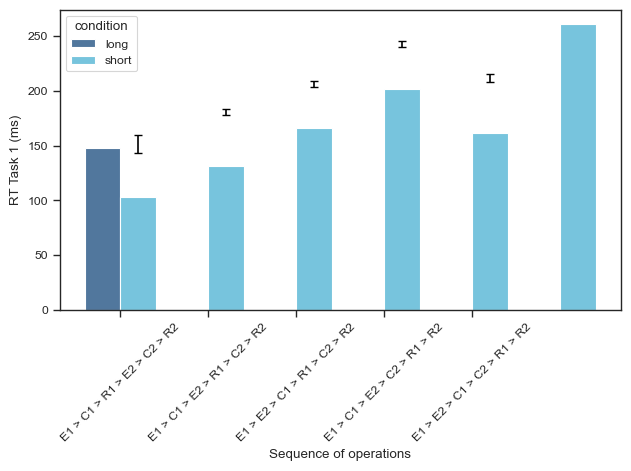

In [35]:
# RT
intercept = model_rt.coefs["Estimate"].iloc[0]
yerrs = (model_rt.coefs["97.5_ci"] - model_rt.coefs["2.5_ci"]) / 2
estimates = model_rt.coefs["Estimate"].copy()
estimates[1:] += intercept
set_seaborn_style()
ax = sns.barplot(data=df, x="order_idx", y="rt_t1", hue="condition", errorbar=None)
# Add custom errorbars
for i, order in enumerate(orders):
    ax.errorbar(i + 0.2, estimates.iloc[i], yerr=yerrs.iloc[i], fmt='none', capsize=3, color='black')
xticks = [' > '.join([legible_labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=45)
plt.xlabel("Sequence of operations")
# plt.ylim(0.7, 1)
plt.ylabel("RT Task 1 (ms)")
plt.tight_layout()
plt.show()

In [ ]:
# Post-hoc multiple comparisons, compare all order_idxs with each other
contrasts = model_rt.post_hoc(
    "order_idx", p_adjust="holm"
)
print(contrasts)

#### Inter-response interval

In [ ]:
# IRI
set_seaborn_style()
df['IRI'] = ((df["rt_samples_t2"] + df["interval_t1"] * 250) - df["rt_samples_t1"]) / 250 * 1000
# df['IRI'] = df["t2_3_pred"] - df["t1_3_pred"]
sns.barplot(data=df, x="order_idx", y="IRI", hue="condition")
xticks = [' > '.join([labels[i] for i in order]) for order in orders]
plt.xticks(range(len(orders)), xticks, rotation=60)
plt.show()

#### Encoding timing

In [ ]:
fig = plot_t1_encoding(df, orders, labels)
fig.show()
fig = plot_t2_encoding(df, orders, labels)
fig.show()

#### RT per order

<Figure size 640x480 with 0 Axes>

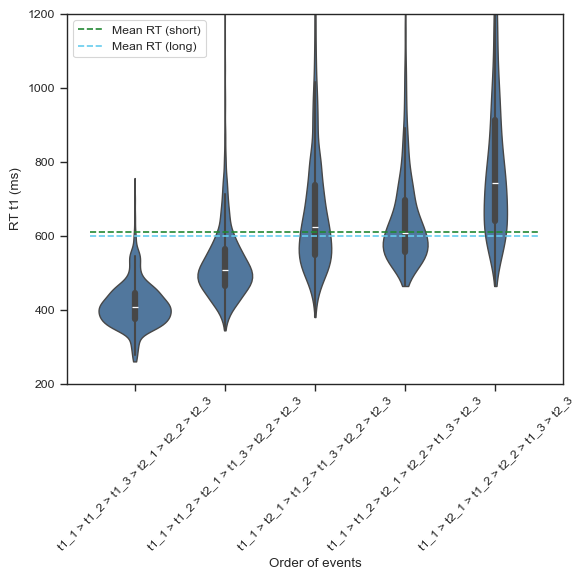

<Figure size 640x480 with 0 Axes>

In [39]:
plot_order_effect_on_rt(df, orders)

In [ ]:
sns.scatterplot(data=df, x= "t1_3_pred", y="rt_samples_t1", hue="condition")

#### Order distribution

  condition               order  Count
0      long  (0, 1, 2, 3, 4, 5)  10925
1     short  (0, 1, 2, 3, 4, 5)    774
2     short  (0, 1, 3, 2, 4, 5)   5422
3     short  (0, 1, 3, 4, 2, 5)    634
4     short  (0, 3, 1, 2, 4, 5)   3059
5     short  (0, 3, 1, 4, 2, 5)   1708
6     short  (0, 3, 4, 1, 2, 5)    181


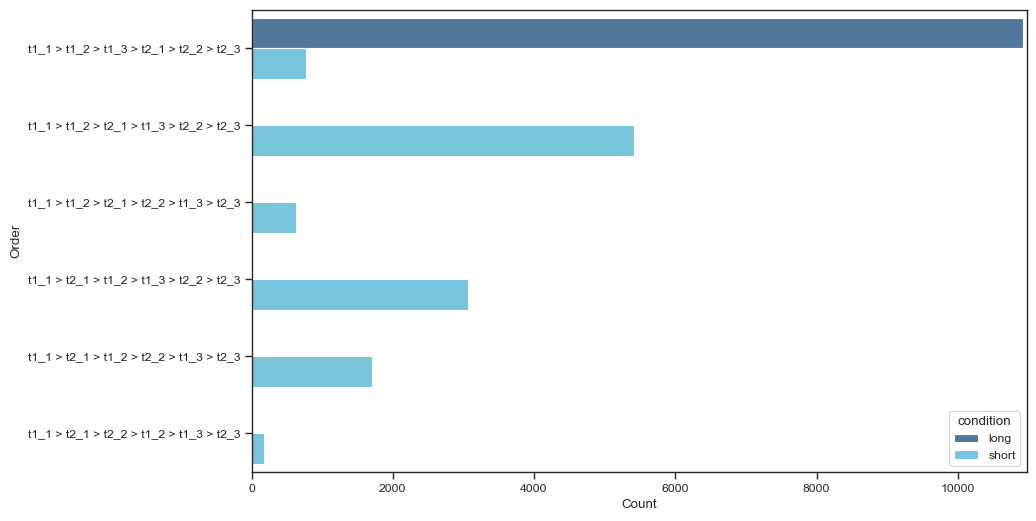

<Figure size 640x480 with 0 Axes>

In [37]:
fig = plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"])
fig.show()
# 11665 short

<Figure size 640x480 with 0 Axes>

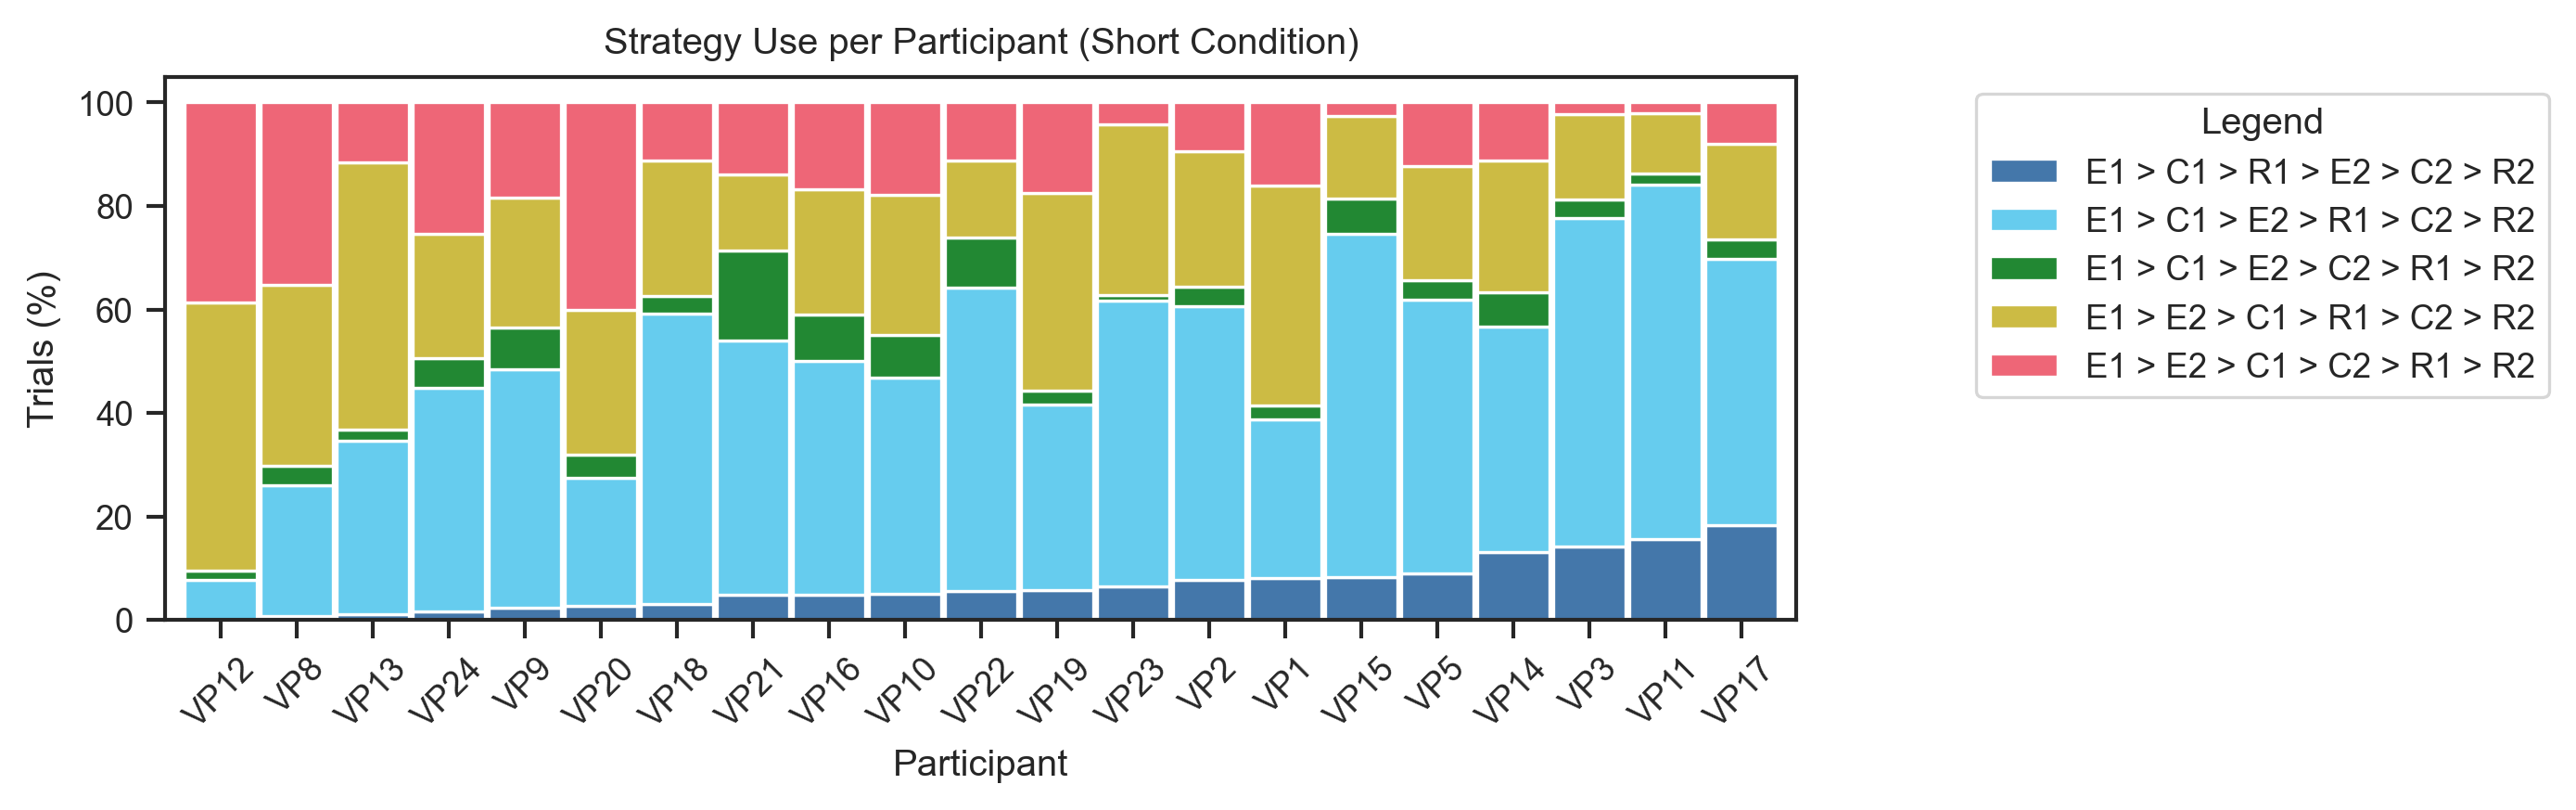

<Figure size 640x480 with 0 Axes>

In [38]:
plot_relative_order_with_rt_lines(df, legible_labels)

<Figure size 640x480 with 0 Axes>

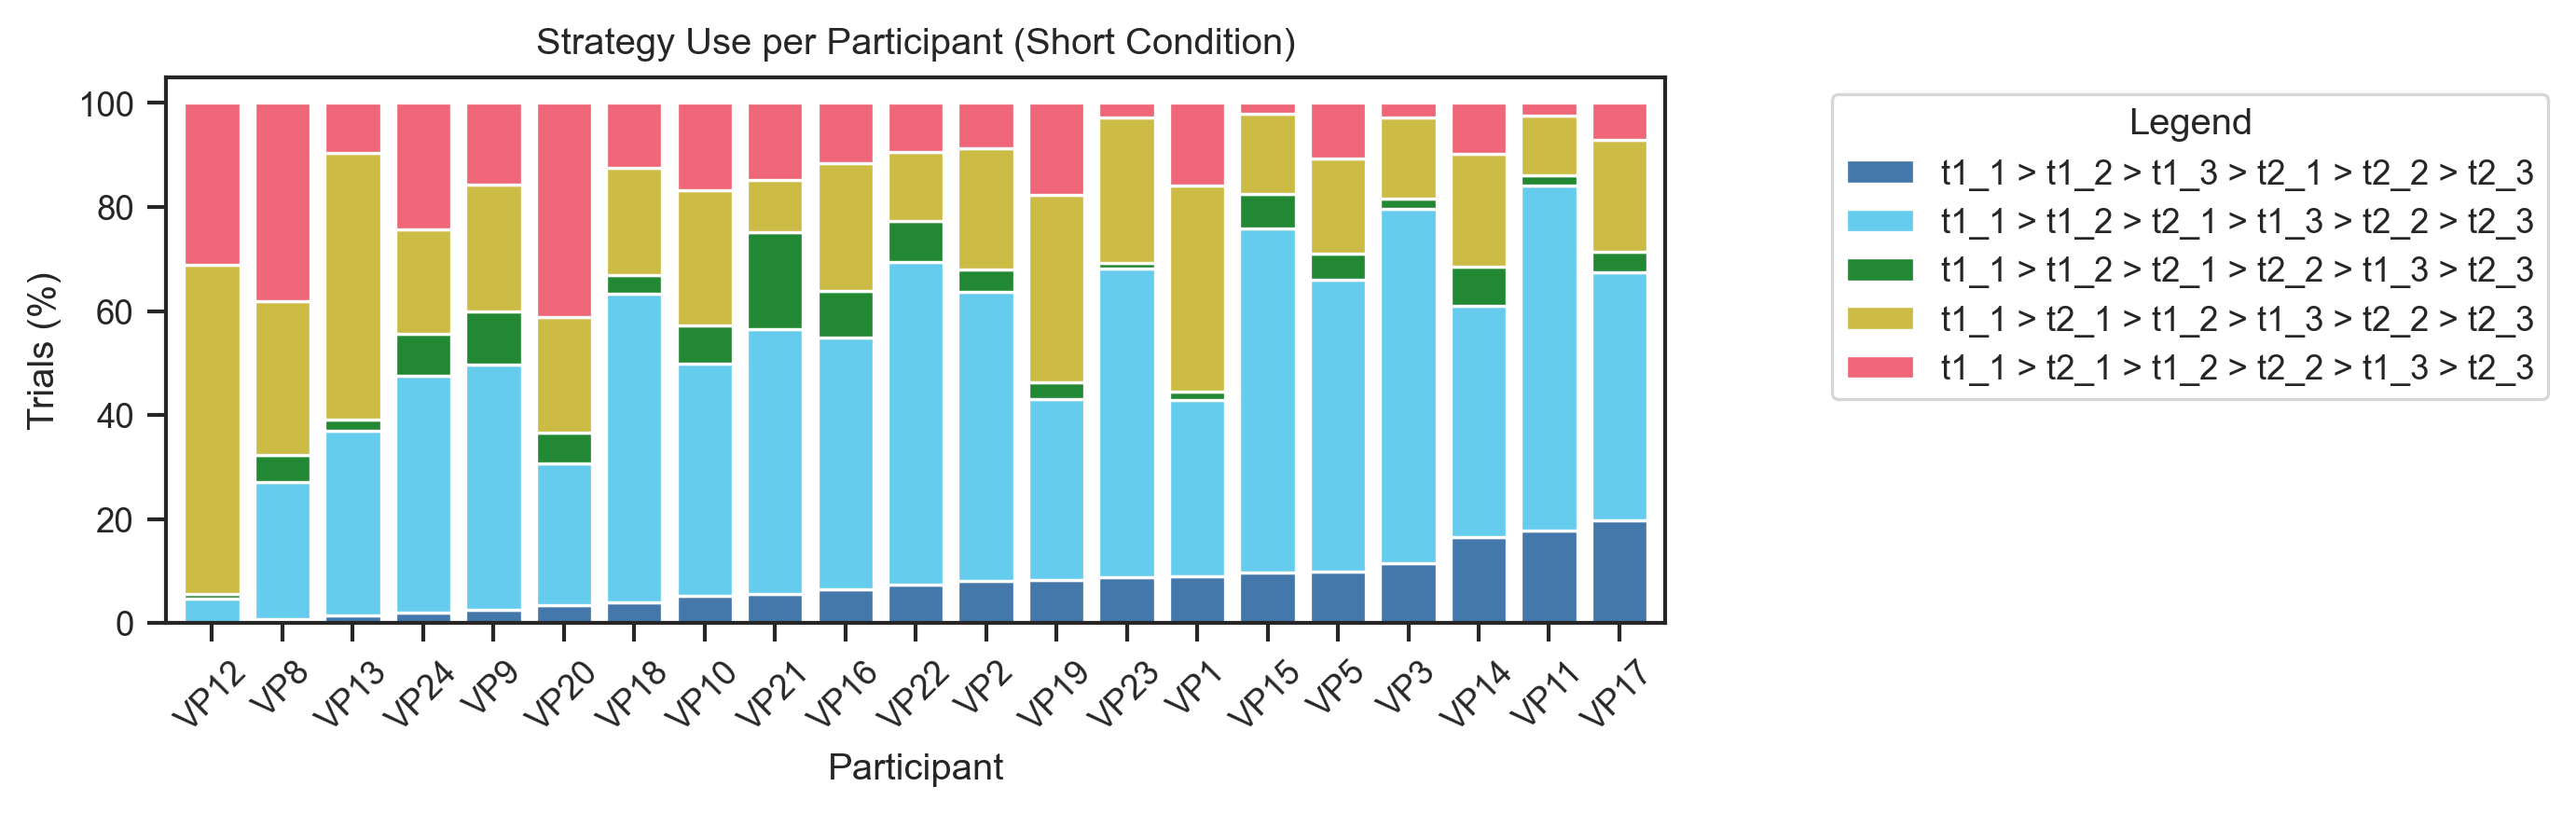

<Figure size 640x480 with 0 Axes>

In [4]:
plot_relative_order_with_rt_lines(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"])

In [ ]:
def plot_strategy_lines_facetgrid(df, labels, bin_size=20):
    # Ensure required columns
    if not {"participant", "epoch", "order", "condition"}.issubset(df.columns):
        raise ValueError("The DataFrame must contain 'participant', 'epoch', 'order', and 'condition' columns.")

    # Filter for short condition
    df_short = df[df["condition"] == "short"].copy()

    # Add readable order label and epoch bins
    df_short["order_label"] = df_short["order"].apply(lambda x: " > ".join([labels[i] for i in x]))
    df_short["epoch_bin"] = (df_short["epoch"] // bin_size) * bin_size

    # Calculate counts and percentages
    counts = (
        df_short.groupby(["participant", "epoch_bin", "order_label"])
        .size()
        .reset_index(name="count")
    )
    counts["total"] = counts.groupby(["participant", "epoch_bin"])["count"].transform("sum")
    counts["percent"] = 100 * counts["count"] / counts["total"]

    # Plot with FacetGrid
    g = sns.FacetGrid(
        counts,
        col="participant",
        col_wrap=3,
        height=4,
        sharey=True
    )
    g.map_dataframe(sns.lineplot, x="epoch_bin", y="percent", hue="order_label", marker="o")

    # Final tweaks
    g.set_axis_labels("Epoch Bin", "Strategy Use (%)")
    g.set_titles("Participant {col_name}")
    g.add_legend(title="Strategy")
    plt.tight_layout()
    plt.show()

plot_strategy_lines_facetgrid(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], bin_size=100)

In [ ]:
def correlate_strategy_with_rt(df, labels):
    # Filter for "short" condition
    df_short = df[df["condition"] == "short"].copy()

    # Count strategies per participant
    order_counts = df_short.groupby(["participant", "order"]).size().reset_index(name="Count")

    # Convert order tuples to readable strings
    order_counts["order"] = order_counts["order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    # Pivot to get percent per strategy per participant
    pivot_df = order_counts.pivot_table(index="participant", columns="order", values="Count", fill_value=0)
    percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    rt_df = df_short.groupby("participant")[["rt_samples_t1", "rt_samples_t2"]].mean()
    rt_df["rt_total"] = rt_df["rt_samples_t1"] + rt_df["rt_samples_t2"]

    # Join RTs to strategy percentages
    analysis_df = percent_df.join(rt_df)
    
    # Compute correlations
    correlation_results = []

    for strategy in percent_df.columns:
        rt1_corr, rt1_p = pearsonr(analysis_df[strategy], analysis_df["rt_samples_t1"])
        rt2_corr, rt2_p = pearsonr(analysis_df[strategy], analysis_df["rt_samples_t2"]) 
        rt_total_corr, rt_total_p = pearsonr(analysis_df[strategy], analysis_df["rt_total"])
        correlation_results.append({
            "Strategy": strategy,
            "RT_t1_r": rt1_corr,
            "RT_t1_p": rt1_p,
            "RT_t2_r": rt2_corr,
            "RT_t2_p": rt2_p,
            "RT_cmb_r": rt_total_corr,
            "RT_cmb_p": rt_total_p
        })

    # Format result as DataFrame
    corr_df = pd.DataFrame(correlation_results)

    return corr_df
correlate_strategy_with_rt(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"])